In [2]:
import itertools
import os
import pickle
import re
import time

import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import scipy
import seaborn
# import tensorflow.keras

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['legend.fontsize'] = 'small'
# pandas.options.display.max_columns = None
# pandas.options.display.max_colwidth = None

# Load data

In [1]:
datasets = [
    {
        'cell_line': 'HEK293T',
        'replicate': 1,
        'path': '../polysome_profiling_sample2019/GSM3130435_egfp_unmod_1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total_reads'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total_reads': 'Reads'},
    },
    {
        'cell_line': 'HEK293T',
        'replicate': 2,
        'path': '../polysome_profiling_sample2019/GSM3130436_egfp_unmod_2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r1.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'T cells',
        'replicate': 2,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_tcell_r2.csv.gz',
        'cols_to_load': ['utr', 'rl', 'total'],
        'cols_to_rename': {'utr': 'UTR', 'rl': 'Observed MRL', 'total': 'Reads'},
    },
    {
        'cell_line': 'HepG2',
        'replicate': 1,
        'path': '../polysome_profiling_data/GSE232927_processed_defined_end_hepg2_r1.csv.gz',
        'cols_to_load': ['UTR', 'rl', 'total'],
        'cols_to_rename': {'rl': 'Observed MRL', 'total': 'Reads'},
    }
]

In [4]:
# Load, preprocess, and compile data
multicol = pandas.MultiIndex(
    levels=[[], [], []],
    codes=[[], [], []],
    names=['Measurement', 'Cell type', 'Replicate'],
)
data_table_combined = pandas.DataFrame(columns=multicol)

for dataset in datasets:
    # Load only desired columns, rename
    data_table = pandas.read_csv(dataset['path'], usecols=dataset['cols_to_load'])
    data_table.rename(columns=dataset['cols_to_rename'], inplace=True)
    data_table['UTR'] = data_table['UTR'].str[:50]
    data_table = data_table.set_index('UTR')
    # # Eliminate the large number of sequences with one read
    # data_table = data_table[data_table['Reads'] > 1]
    # Eliminate sequences with low number of reads
    data_table = data_table[data_table['Reads'] > 50]

    # Convert to multiindex
    data_table = data_table[['Reads', 'Observed MRL']]
    multicol = pandas.MultiIndex.from_product(
        [['Reads', 'Observed MRL'], [dataset['cell_line']], [dataset['replicate']]],
        names=['Measurement', 'Cell type', 'Replicate'],
    )
    data_table.columns = multicol

    # Store
    data_table_combined = data_table_combined.merge(data_table, how='outer', left_index=True, right_index=True)
    
    print("{:,} sequences loaded for cell line {} rep {}.".format(len(data_table), dataset['cell_line'], dataset['replicate']))

# Set NaN reads to zero
data_table_combined['Reads'] = data_table_combined['Reads'].fillna(0)

# Add uATG
data_table_combined['uATG'] = False
data_table_combined.loc[data_table_combined.index.str.contains('ATG'), 'uATG'] = True
# data_table_combined.loc[~data_table_combined.index.str.contains('ATG'), 'uATG'] = False

display(data_table_combined)

316,243 sequences loaded for cell line HEK293T rep 1.
287,356 sequences loaded for cell line HEK293T rep 2.
273,563 sequences loaded for cell line T cells rep 1.
291,229 sequences loaded for cell line T cells rep 2.
354,467 sequences loaded for cell line HepG2 rep 1.


Measurement,Reads,Observed MRL,Reads,Observed MRL,Reads,Observed MRL,Reads,Observed MRL,Reads,Observed MRL,uATG
Cell type,HEK293T,HEK293T,HEK293T,HEK293T,T cells,T cells,T cells,T cells,HepG2,HepG2,
Replicate,1,1,2,2,1,1,2,2,1,1,
UTR,,,,,,,,,,,
AAAAAAAAAACTATACTAGGAAAGACATCTTGCTAGGGATGCTCTGGGAT,67.0,7.853498,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,True
AAAAAAAAACAAGACACTAACGGGTTAATTCAGAGAAAATAGCTAAACCG,155.0,8.469798,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,False
AAAAAAAAACACTGACTTAATTGCATCTGGAAAAGAGTGCCTGCCGACCG,104.0,8.784713,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,False
AAAAAAAACGATTATGTAGTTCCAGGAAAGAGTTGAAACAGTTCAAATAA,93.0,5.255923,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,True
AAAAAAAACGGCTGCGGCGCCCTCCGTGGCGTCCATCAGTCATATACACA,1117.0,6.724805,244.0,5.631148,322.0,6.188550,353.0,6.112066,99.0,3.758071,False
...,...,...,...,...,...,...,...,...,...,...,...
TTTTTTGTAACGGCACCAGGGATATACCTTCAAAGCCGGACGTTTGTCAT,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,57.0,2.325570,False


# k-mer functions

In [5]:
def count_strided_kmers(s, k, st=1):
    '''
    Count k-mers on strings.

    Optionally specify a stride value. In this case, k-mers will only
    be counted together if they occur at the same phase with respect
    to the stride value.
    
    Parameters
    ----------
    s : list
        List of strings on which to count k-mers.
    k : int
        k in k-mer
    st : int
        Stride value
        
    Returns
    -------
    array
        Size (len(s), k*st). The i,j -th element corresponds to how many
        instances of k-mer `kmer[j%k]` occur in string `s[i]`, starting
        at position `l` such that ``l%st == j//k``.

    '''
    # list all k-mers
    bases = ['A', 'C', 'G', 'T']
    kmers = bases.copy()
    for ki in range(k - 1):
        kmers = [kmer + base for kmer, base in itertools.product(kmers, bases)]
    # Dictionary with k-mers as keys and their respective indices in `kmers` as values
    kmer_dict = dict(zip(kmers, range(len(kmers))))
    # List of extended kmers for output
    if st > 1:
        ext_kmers = [f"{sti + 1}-{kmer}" for sti, kmer in itertools.product(range(st), kmers)]
    else:
        ext_kmers = kmers

    # Count k-mers on all strings
    counts = numpy.zeros((len(s), len(kmer_dict)*st))
    for i in range(len(s)):
        si = s[i]
        for j in range(len(s[i]) - k + 1):
            kmer_idx = kmer_dict[si[j:j+k]]
            counts[i, kmer_idx + j%st*len(kmer_dict)] += 1
            
    return ext_kmers, counts

In [6]:
# Test
ext_kmers, counts = count_strided_kmers(['ACTGACTG', 'CGATCATCACTGACA'], k=3, st=6)
for counts_seq in counts:
    ext_kmers_reduced = [ext_kmer for ext_kmer, count in zip(ext_kmers, counts_seq) if count>0]
    counts_seq_reduced = counts_seq[counts_seq > 0]
    print(dict(zip(ext_kmers_reduced, counts_seq_reduced)))


{'1-ACT': 1.0, '2-CTG': 1.0, '3-TGA': 1.0, '4-GAC': 1.0, '5-ACT': 1.0, '6-CTG': 1.0}
{'1-ACA': 1.0, '1-CGA': 1.0, '1-TCA': 1.0, '2-CAC': 1.0, '2-GAT': 1.0, '3-ACT': 1.0, '3-ATC': 1.0, '4-CTG': 1.0, '4-TCA': 1.0, '5-CAT': 1.0, '5-TGA': 1.0, '6-ATC': 1.0, '6-GAC': 1.0}


# Fit to linear model

In [7]:
import tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

# Attempt to not crash the gpu memory
# Based on https://stackoverflow.com/questions/65723891/how-to-free-tf-keras-memory-in-python-after-a-model-has-been-deleted-while-othe
# Post run note: didn't work :(
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tensorflow.config.experimental.set_memory_growth(gpu, True)

In [8]:
def train_linear_model(data_train_x, data_train_y, data_train_w, data_val_x, data_val_y, data_val_w, alpha=0):
    # Define model: only a dense layer with linear activation (linear regression)
    # and L2 regularization
    model = Sequential()
    model.add(
        Dense(
            1,
            activation='linear',
            kernel_regularizer=regularizers.l2(alpha),
            bias_regularizer=regularizers.l2(alpha),
        )
    )

    # Compile the model and train
    epochs = 50
    batch_size = 512
    learning_rate = 0.01

    # Callback: stop training after no improvement in validation
    callbacks = [
        tensorflow.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
        ),
    ]

    adam = tensorflow.keras.optimizers.Adam(learning_rate)
    model.compile(loss='mean_squared_error', optimizer=adam)

    training_history = model.fit(
        data_train_x,
        data_train_y,
        sample_weight=data_train_w*len(data_train_w),
        validation_data=(data_val_x, data_val_y, data_val_w*len(data_val_w)),
        batch_size=batch_size,
        epochs=epochs,
        shuffle=True,
        callbacks=callbacks,
        verbose=1,
    )

    return model, training_history

In [9]:
# Parameters of linear model to use
k = 3
st = 48

In [10]:
# Find the optimal value of the alpha regularization parameter
cell_line = 'HEK293T'
replicate = 1
alpha_values = [0, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1]

# Load run info so far
try:
    kmer_alpha_table = pandas.read_csv(f'kmer_alpha_dataset_k_{k}_st_{st}.csv', index_col=0)
except FileNotFoundError as e:
    kmer_alpha_table = pandas.DataFrame(columns=['Training wMSE', 'Validation wMSE'])

# Extract data corresponding to current cell line
data_table = data_table_combined.loc[
    :,
    (
        slice(None),
        cell_line,
        replicate,   
    )
]
data_table.columns = data_table.columns.droplevel([1, 2])
# Replace all nans in MRL column with zeros to avoid issues later
data_table = data_table.fillna(0)
# Eliminate all rows with zeros in all reads
data_table = data_table[data_table['Reads'] > 0]

# Sort by number of reads
data_table = data_table.sort_values('Reads', ascending=False)

# Separate into training and test subsets
data_test = data_table.iloc[:20000]
data_val = data_table.iloc[20000:22000]
data_train = data_table.iloc[22000:]

# Preprocess training data: count kmers in input, obtain weight by normalizing reads
norm_outputs = lambda x: (x - numpy.mean(x))/numpy.std(x)
norm_weights = lambda x: x/numpy.sum(x)

_, data_train_x = count_strided_kmers(data_train.index, k=k, st=st)
data_train_y = norm_outputs(data_train['Observed MRL'].values)
data_train_w = norm_weights(data_train['Reads'].values)

_, data_val_x = count_strided_kmers(data_val.index, k=k, st=st)
data_val_y = norm_outputs(data_val['Observed MRL'].values)
data_val_w = norm_weights(data_val['Reads'].values)

_, data_test_x = count_strided_kmers(data_test.index, k=k, st=st)
data_test_y = norm_outputs(data_test['Observed MRL'].values)
data_test_w = norm_weights(data_test['Reads'].values)

# Training model for each alpha value
for alpha_value in alpha_values:

    if alpha_value in kmer_alpha_table.index:
        print(f"Data for alpha value {alpha_value:.2e} already available. Skipping...")
        continue

    print(f"Training model for alpha value {alpha_value:.2e}...")
    model, training_history = train_linear_model(
        data_train_x,
        data_train_y,
        data_train_w,
        data_val_x,
        data_val_y,
        data_val_w,
        alpha=alpha_value,
    )

    # # Generate predictions
    # train_pred = model.predict(data_train_x).flatten()
    # val_pred = model.predict(data_val_x).flatten()
    # # test_pred = model.predict(data_test_x).flatten()
    # # Calculate MSE
    # train_mse = numpy.sum((train_pred - data_train_y)**2*data_train_w)/len(train_pred)*len(data_train_w)
    # val_mse = numpy.sum((val_pred - data_val_y)**2*data_val_w)/len(val_pred)*len(data_val_w)
    # # test_mse = numpy.sum((test_pred - data_test_y)**2*data_test_w)/len(test_pred)*len(data_test_w)
    # train_mse_values.append(train_mse)
    # val_mse_values.append(val_mse)

    # Extract losses from training history
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    min_loss_index = numpy.argmin(val_loss)

    train_mse = train_loss[min_loss_index]
    val_mse = val_loss[min_loss_index]
    
    kmer_alpha_table.at[alpha_value, 'Training wMSE'] = train_mse
    kmer_alpha_table.at[alpha_value, 'Validation wMSE'] = val_mse

    kmer_alpha_table.to_csv(f'kmer_alpha_dataset_k_{k}_st_{st}.csv')

    # Try to release memory
    # Will probably fail for large enough models
    del(model)
    tensorflow.keras.backend.clear_session()
    time.sleep(5)

kmer_alpha_table

Data for alpha value 0.00e+00 already available. Skipping...
Data for alpha value 3.00e-06 already available. Skipping...
Data for alpha value 1.00e-05 already available. Skipping...
Data for alpha value 3.00e-05 already available. Skipping...
Data for alpha value 1.00e-04 already available. Skipping...
Data for alpha value 3.00e-04 already available. Skipping...
Data for alpha value 1.00e-03 already available. Skipping...
Data for alpha value 3.00e-03 already available. Skipping...
Data for alpha value 1.00e-02 already available. Skipping...
Data for alpha value 3.00e-02 already available. Skipping...
Data for alpha value 1.00e-01 already available. Skipping...


,Training wMSE,Validation wMSE
0.000000,0.443198,0.419726
0.000003,0.421569,0.419024
0.000010,0.421250,0.413173
0.000030,0.444726,0.428460
0.000100,0.423409,0.414940
0.000300,0.429277,0.415824
0.001000,0.471731,0.432936
0.003000,0.495871,0.483956
0.010000,0.612908,0.595389
0.030000,0.772745,0.752061


In [11]:
# Load alpha scan data
kmer_alpha_table = pandas.read_csv(f'kmer_alpha_dataset_k_{k}_st_{st}.csv', index_col=0)
kmer_alpha_table

,Training wMSE,Validation wMSE
0.000000,0.443198,0.419726
0.000003,0.421569,0.419024
0.000010,0.421250,0.413173
0.000030,0.444726,0.428460
0.000100,0.423409,0.414940
0.000300,0.429277,0.415824
0.001000,0.471731,0.432936
0.003000,0.495871,0.483956
0.010000,0.612908,0.595389
0.030000,0.772745,0.752061


Best alpha = 1.00e-05


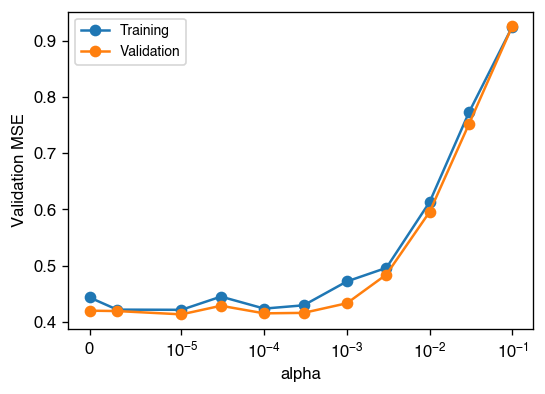

In [12]:
# Choose alpha that results in minimum validation MSE
opt_alpha = kmer_alpha_table.idxmin()['Validation wMSE']
print(f"Best alpha = {opt_alpha:.2e}")

# Plot MSE vs. alpha
fig, ax = pyplot.subplots(figsize=(5, 3.5))
ax.plot(kmer_alpha_table['Training wMSE'], marker='o', label='Training')
ax.plot(kmer_alpha_table['Validation wMSE'], marker='o', label='Validation')
ax.set_xscale('symlog', linthresh=1e-5)
ax.set_xlabel('alpha')
ax.set_ylabel('Validation MSE')
ax.legend()

In [13]:
# Calculate parameters for each dataset

# Load run info so far
try:
    kmer_weight_table = pandas.read_csv(f'kmer_weights_dataset_k_{k}_st_{st}.csv', index_col=0, header=[0, 1])
    kmer_weight_table.columns = kmer_weight_table.columns.set_levels(
        kmer_weight_table.columns.levels[1].astype(int),
        level=1,
    )
except FileNotFoundError as e:
    # Make dataframe to store parameters
    ext_kmers, _ = count_strided_kmers(data_table.iloc[:10].index, k=k, st=st)
    columns = pandas.MultiIndex(
        levels=[[], []],
        codes=[[], []],
        names=[u'Cell type', u'Replicate'],
    )
    kmer_weight_table = pandas.DataFrame(index=ext_kmers+['b'], columns=columns)

for dataset in datasets:
    cell_line = dataset['cell_line']
    replicate = dataset['replicate']

    if (cell_line, replicate) in kmer_weight_table.columns:
        print(f"Data for cell line {cell_line} replicate {replicate} already available. Skipping...")
        continue

    print(f"Fitting model to data from cell line {cell_line} replicate {replicate}...")
    # Extract data corresponding to current cell line
    data_table = data_table_combined.loc[
        :,
        (
            slice(None),
            cell_line,
            replicate,   
        )
    ]
    data_table.columns = data_table.columns.droplevel([1, 2])
    # Replace all nans in MRL column with zeros to avoid issues later
    data_table = data_table.fillna(0)
    # Eliminate all rows with zeros in all reads
    data_table = data_table[data_table['Reads'] > 0]

    data_table = data_table.sort_values('Reads', ascending=False)

    # Separate into training and test subsets
    data_test = data_table.iloc[:20000]
    data_val = data_table.iloc[20000:22000]
    data_train = data_table.iloc[22000:]

    # Preprocess training data: count kmers in input, obtain weight by normalizing reads
    norm_outputs = lambda x: (x - numpy.mean(x))/numpy.std(x)
    norm_weights = lambda x: x/numpy.sum(x)

    _, data_train_x = count_strided_kmers(data_train.index, k=k, st=st)
    data_train_y = norm_outputs(data_train['Observed MRL'].values)
    data_train_w = norm_weights(data_train['Reads'].values)

    _, data_val_x = count_strided_kmers(data_val.index, k=k, st=st)
    data_val_y = norm_outputs(data_val['Observed MRL'].values)
    data_val_w = norm_weights(data_val['Reads'].values)

    _, data_test_x = count_strided_kmers(data_test.index, k=k, st=st)
    data_test_y = norm_outputs(data_test['Observed MRL'].values)
    data_test_w = norm_weights(data_test['Reads'].values)

    # Training model
    model, training_history = train_linear_model(
        data_train_x,
        data_train_y,
        data_train_w,
        data_val_x,
        data_val_y,
        data_val_w,
        alpha=opt_alpha,
    )

    # Save model
    model.save(f'kmer_weights_dataset_k_{k}_st_{st}_{cell_line}_rep{replicate}.h5')

    # Get and store weights
    w, b = model.layers[0].get_weights()
    kmer_weight_table[cell_line, replicate] = numpy.append(w, b)
    
    # Save progress so far
    kmer_weight_table.to_csv(f'kmer_weights_dataset_k_{k}_st_{st}.csv')

    # Try to release memory
    # Will probably fail for large enough models
    del(model)
    tensorflow.keras.backend.clear_session()
    time.sleep(5)

kmer_weight_table

Data for cell line HEK293T replicate 1 already available. Skipping...
Data for cell line HEK293T replicate 2 already available. Skipping...
Data for cell line T cells replicate 1 already available. Skipping...
Data for cell line T cells replicate 2 already available. Skipping...
Fitting model to data from cell line HepG2 replicate 1...
Epoch 1/50
650/650 [==============================] - 4s 4ms/step - loss: 0.5784 - val_loss: 0.5316
Epoch 2/50
650/650 [==============================] - 2s 3ms/step - loss: 0.5662 - val_loss: 0.5471
Epoch 3/50
650/650 [==============================] - 2s 4ms/step - loss: 0.5669 - val_loss: 0.5250
Epoch 4/50
650/650 [==============================] - 2s 4ms/step - loss: 0.5673 - val_loss: 0.5507
Epoch 5/50
650/650 [==============================] - 2s 3ms/step - loss: 0.5662 - val_loss: 0.5357
Epoch 6/50
650/650 [==============================] - 2s 3ms/step - loss: 0.5669 - val_loss: 0.5558
Epoch 7/50
650/650 [==============================] - 2s 3ms/s

Cell type   HEK293T             T cells               HepG2
Replicate         1         2         1         2         1
1-AAA     -0.007423  0.007177 -0.019239  0.091116 -0.001456
1-AAC      0.015167  0.020960 -0.018971  0.047856  0.038351
1-AAG     -0.009047  0.032138 -0.008918 -0.004280  0.033606
1-AAT     -0.152715 -0.108885 -0.114703 -0.014888 -0.061832
1-ACA      0.032316  0.044220 -0.018661 -0.025352 -0.048621
...             ...       ...       ...       ...       ...
48-TTA     0.072298  0.058381  0.064546  0.069701  0.069206
48-TTC     0.033514  0.142465  0.051559  0.002538  0.070999
48-TTG    -0.006969  0.004162 -0.000902  0.022539 -0.031226
48-TTT     0.002942 -0.028586  0.011426  0.029946 -0.008568
b         -0.089566 -0.064826 -0.067639 -0.070440 -0.006879

[3073 rows x 5 columns]

# Analyze results

In [14]:
k = 3
st = 48

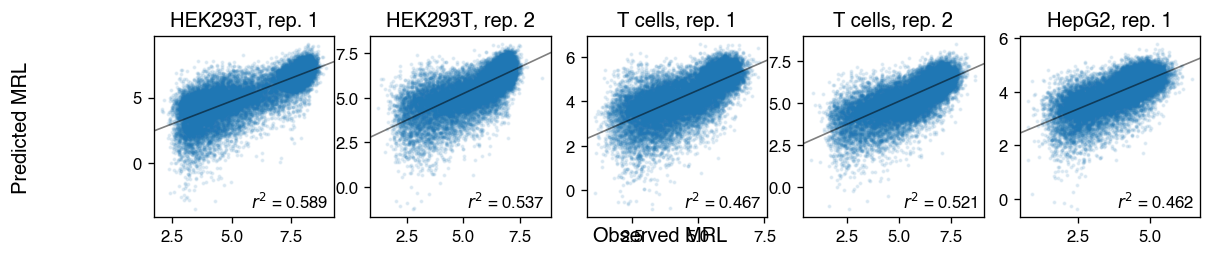

In [43]:
# Make correlation plots with predictions
fig, axes = pyplot.subplots(
    1,
    len(datasets),
    figsize=(2.25*len(datasets), 2.)
)

for dataset_idx, dataset in enumerate(datasets):
    cell_line = dataset['cell_line']
    replicate = dataset['replicate']

    # Extract data corresponding to current cell line
    data_table = data_table_combined.loc[
        :,
        (
            slice(None),
            cell_line,
            replicate,
        )
    ]
    data_table.columns = data_table.columns.droplevel([1, 2])
    # Replace all nans in MRL column with zeros to avoid issues later
    data_table = data_table.fillna(0)
    # Eliminate all rows with zeros in all reads
    data_table = data_table[data_table['Reads'] > 0]

    data_table = data_table.sort_values('Reads', ascending=False)

    # Separate into training and test subsets
    data_test = data_table.iloc[:20000]

    # Preprocess data: count kmers in input, obtain weight by normalizing reads
    norm_outputs = lambda x: (x - numpy.mean(x))/numpy.std(x)
    unnorm_outputs = lambda x, z: z*numpy.std(x) + numpy.mean(x)
    norm_weights = lambda x: x/numpy.sum(x)

    _, data_test_x = count_strided_kmers(data_test.index, k=k, st=st)
    data_test_y = norm_outputs(data_test['Observed MRL'].values)
    data_test_w = norm_weights(data_test['Reads'].values)

    # Load model
    model = tensorflow.keras.models.load_model(f'kmer_weights_dataset_k_{k}_st_{st}_{cell_line}_rep{replicate}.h5')

    # Make prediction
    data_test_y_pred = model.predict(data_test_x).reshape(-1)

    # Unnormalize
    data_to_plot_x = data_test['Observed MRL'].values
    data_to_plot_y = unnorm_outputs(data_test['Observed MRL'].values, data_test_y_pred)

    # Generate scatter plot
    ax = axes[dataset_idx]
    ax.scatter(
        data_to_plot_x,
        data_to_plot_y,
        s=2,
        alpha=0.1,
        rasterized=True,
    )
    # ax.set_xlim(1, 9)
    # ax.set_ylim(-2, 9)

    # Regression line and r^2 text
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
        data_to_plot_x,
        data_to_plot_y,
    )
    ax.axline((3, 3*slope + intercept), slope=slope, color='k', linewidth=1, alpha=0.5)
    r2_text = f'$r^2$ = {r_value**2:.3f}'
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xcoord = xlim[0] + 0.97*(xlim[1] - xlim[0])
    ycoord = ylim[0] + 0.05*(ylim[1] - ylim[0])
    ax.text(xcoord, ycoord, r2_text, ha='right')
    
    ax.set_title(f"{cell_line}, rep. {replicate}")

    # ax.set_ylim(ax.get_xlim())
fig.supxlabel('Observed MRL')
fig.supylabel('Predicted MRL')

fig.savefig(f'kmer_MRL_dataset_k_{k}_st_{st}_scatter.svg', dpi=200, bbox_inches='tight')
fig.savefig(f'kmer_MRL_dataset_k_{k}_st_{st}_scatter.png', dpi=200, bbox_inches='tight')

In [33]:
# Load weight data
kmer_weight_table = pandas.read_csv(f'kmer_weights_dataset_k_{k}_st_{st}.csv', index_col=0, header=[0, 1])
kmer_weight_table.columns = kmer_weight_table.columns.set_levels(
    kmer_weight_table.columns.levels[1].astype(int),
    level=1,
)
kmer_weight_table

Cell type   HEK293T             T cells               HepG2
Replicate         1         2         1         2         1
1-AAA     -0.007423  0.007177 -0.019239  0.091116 -0.001456
1-AAC      0.015167  0.020960 -0.018971  0.047856  0.038351
1-AAG     -0.009047  0.032138 -0.008918 -0.004280  0.033606
1-AAT     -0.152715 -0.108885 -0.114703 -0.014888 -0.061832
1-ACA      0.032316  0.044220 -0.018661 -0.025352 -0.048621
...             ...       ...       ...       ...       ...
48-TTA     0.072298  0.058381  0.064546  0.069701  0.069206
48-TTC     0.033514  0.142465  0.051559  0.002538  0.070999
48-TTG    -0.006969  0.004162 -0.000902  0.022539 -0.031226
48-TTT     0.002942 -0.028586  0.011426  0.029946 -0.008568
b         -0.089566 -0.064826 -0.067639 -0.070440 -0.006879

[3073 rows x 5 columns]

In [34]:
for i, dataset_i in enumerate(datasets):
    for j, dataset_j in enumerate(datasets):

        # Disable axes if above diagonal
        if i >= j:
            continue
            
        else:
            # Extract cell line and replicate from each dataset
            cell_line_i = dataset_i['cell_line']
            replicate_i = dataset_i['replicate']
            cell_line_j = dataset_j['cell_line']
            replicate_j = dataset_j['replicate']

            # Extract data to plot from selected datasets
            kmer_diff_table = kmer_weight_table.loc[
                :,
                [
                    (cell_line_i, replicate_i),
                    (cell_line_j, replicate_j),
                ]
            ]

            kmer_diff_table.at[:, 'Abs diff'] = numpy.abs(
                kmer_diff_table.loc[:, (cell_line_i, replicate_i)] - \
                kmer_diff_table.loc[:, (cell_line_j, replicate_j)]
            )
            kmer_diff_table = kmer_diff_table.sort_values('Abs diff', ascending=False)
            display(kmer_diff_table)

            

Cell type   HEK293T            Abs diff
Replicate         1         2          
40-TTG     0.285398  0.076760  0.208638
21-CAT    -0.205618 -0.001388  0.204230
47-GCT     0.102836 -0.076188  0.179024
30-TAC     0.224650  0.050309  0.174341
48-TGG    -0.464691 -0.636809  0.172117
...             ...       ...       ...
46-CTT    -0.083886 -0.084103  0.000217
35-CAC     0.034258  0.034423  0.000165
30-CGT     0.054422  0.054340  0.000082
26-TAT     0.038049  0.038109  0.000059
36-ATC     0.024730  0.024689  0.000041

[3073 rows x 3 columns]

Cell type,HEK293T,T cells,Abs diff
Replicate,1,1,
4-ATG,-0.649135,-0.451842,0.197293
12-CGG,-0.046499,0.149618,0.196116
41-ATT,0.305805,0.115508,0.190298
38-ATG,-0.656748,-0.468777,0.187971
15-CCT,0.108774,-0.073590,0.182363
...,...,...,...
1-AAG,-0.009047,-0.008918,0.000129
35-GGA,0.007987,0.007872,0.000115
28-CCT,0.023245,0.023135,0.000110


Cell type,HEK293T,T cells,Abs diff
Replicate,1,2,
1-TTT,0.090793,0.348914,0.258121
11-ATT,0.409694,0.199868,0.209826
1-TGA,-0.090576,0.118111,0.208687
1-CAC,0.048253,-0.147130,0.195383
1-TTA,0.038535,0.233010,0.194475
...,...,...,...
26-GAT,-0.015109,-0.014915,0.000193
14-GTG,0.225468,0.225627,0.000159
6-CAG,0.098415,0.098264,0.000150


Cell type,HEK293T,HepG2,Abs diff
Replicate,1,1,
48-TGG,-0.464691,-0.248228,0.216463
11-ATT,0.409694,0.196293,0.213401
37-ATG,-0.598681,-0.394937,0.203744
2-TCT,-0.036314,0.167181,0.203496
15-ATG,-0.131345,-0.325543,0.194198
...,...,...,...
10-CGT,0.066861,0.066934,0.000073
45-GTG,0.027725,0.027797,0.000072
3-CCA,-0.056570,-0.056635,0.000065


Cell type,HEK293T,T cells,Abs diff
Replicate,2,1,
48-TGG,-0.636809,-0.410301,0.226507
1-GGG,-0.111122,0.109402,0.220524
33-TGA,-0.350838,-0.132642,0.218196
38-ATG,-0.659793,-0.468777,0.191017
46-TGC,-0.064482,0.123484,0.187966
...,...,...,...
44-TGA,-0.037199,-0.037100,0.000099
34-CTC,-0.013125,-0.013194,0.000069
39-GTC,-0.036289,-0.036222,0.000068


Cell type,HEK293T,T cells,Abs diff
Replicate,2,2,
1-TGA,-0.142209,0.118111,0.260320
48-TGG,-0.636809,-0.387412,0.249397
1-TGT,-0.240146,0.006508,0.246654
1-TTT,0.141333,0.348914,0.207581
1-CAC,0.044219,-0.147130,0.191349
...,...,...,...
15-CAA,0.017066,0.017025,0.000042
47-GAC,0.011081,0.011039,0.000042
29-TAT,0.033600,0.033566,0.000033


Cell type,HEK293T,HepG2,Abs diff
Replicate,2,1,
48-TGG,-0.636809,-0.248228,0.388580
47-ATC,0.318249,0.077457,0.240792
43-ATT,0.267237,0.046424,0.220812
2-TCT,-0.028134,0.167181,0.195316
38-ATG,-0.659793,-0.469110,0.190684
...,...,...,...
35-TAT,0.029207,0.029110,0.000097
23-ACC,0.029198,0.029122,0.000076
2-CTT,0.046852,0.046923,0.000071


Cell type   T cells            Abs diff
Replicate         1         2          
1-TTT      0.008825  0.348914  0.340089
1-TAT     -0.092281  0.165280  0.257561
1-TTA      0.016363  0.233010  0.216646
1-CAC      0.062201 -0.147130  0.209331
1-TGA     -0.089434  0.118111  0.207545
...             ...       ...       ...
2-CAC      0.020770  0.020627  0.000143
46-TCT     0.030720  0.030801  0.000081
25-ACA     0.005249  0.005174  0.000075
20-TGG    -0.184435 -0.184485  0.000050
10-ATG    -0.545635 -0.545595  0.000039

[3073 rows x 3 columns]

Cell type,T cells,HepG2,Abs diff
Replicate,1,1,
46-GCT,0.095525,-0.126552,0.222077
15-ATG,-0.126722,-0.325543,0.198820
12-TAG,0.127094,-0.065994,0.193088
23-CTT,-0.087530,0.103602,0.191132
14-ATA,0.322072,0.134977,0.187094
...,...,...,...
27-CGA,-0.000763,-0.000882,0.000120
17-TTT,0.038810,0.038925,0.000114
10-GCA,-0.042381,-0.042443,0.000062


Cell type,T cells,HepG2,Abs diff
Replicate,2,1,
1-TTT,0.348914,0.063728,0.285186
1-TGA,0.118111,-0.158405,0.276516
1-TAT,0.165280,-0.110802,0.276082
1-CGA,-0.164371,0.108779,0.273150
15-ATG,-0.072937,-0.325543,0.252606
...,...,...,...
21-GAG,-0.018650,-0.018624,0.000026
22-GGA,-0.066029,-0.066051,0.000023
26-CTT,0.003535,0.003520,0.000015


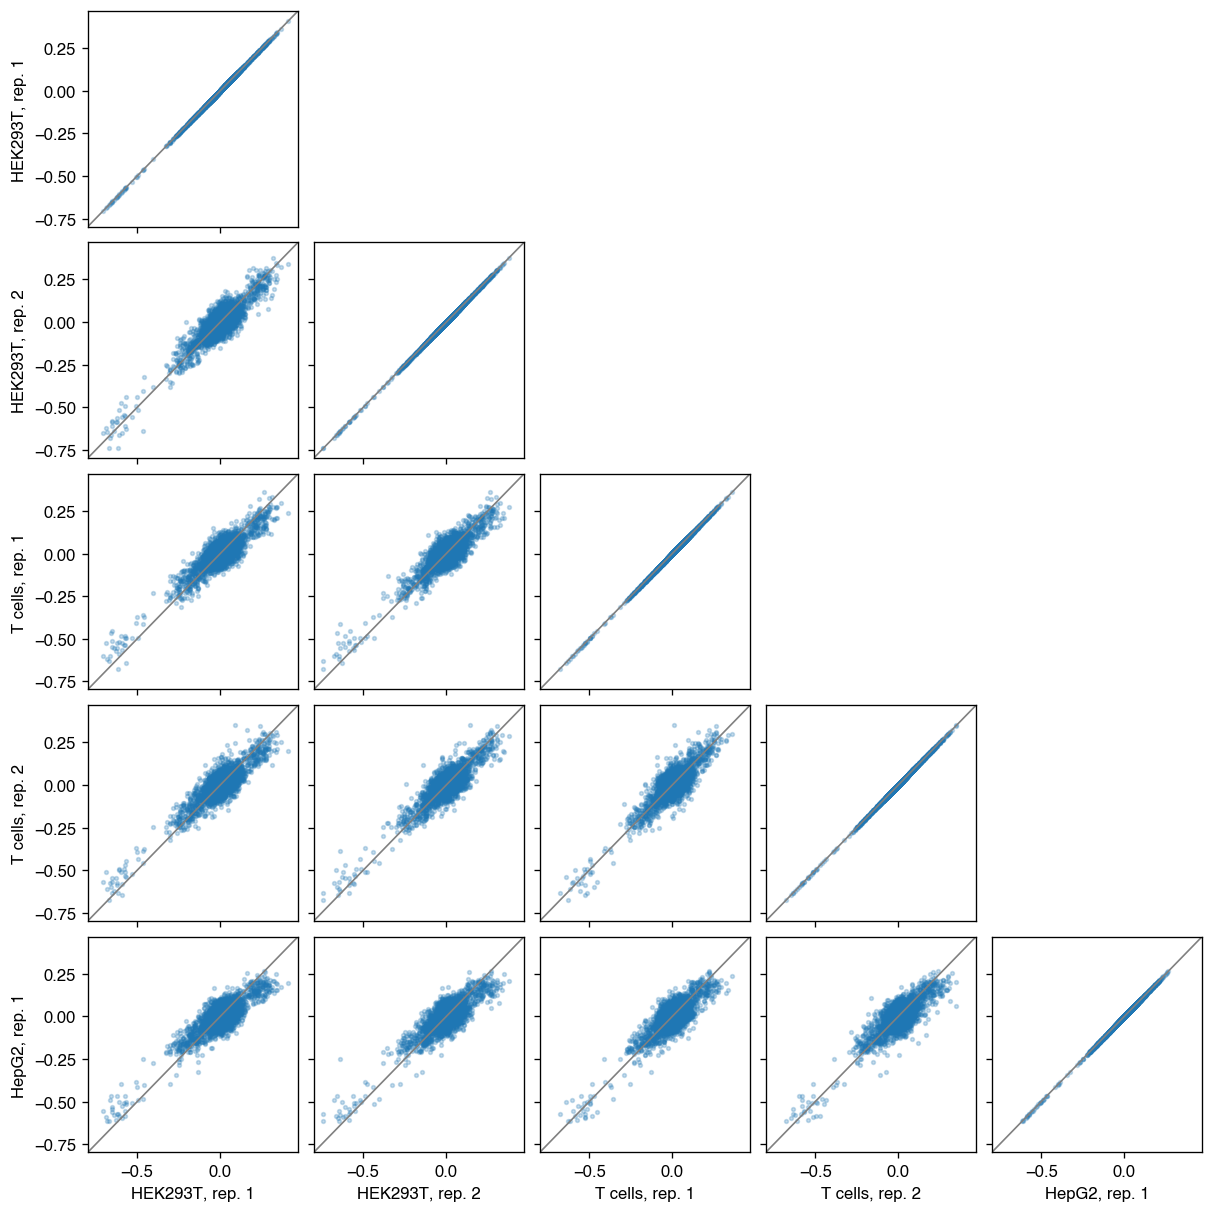

In [40]:
# Scatter plot weights vs. weights
fig, axes = pyplot.subplots(
    len(datasets),
    len(datasets),
    figsize=(2.*len(datasets), 2.*len(datasets)),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)
for i, dataset_i in enumerate(datasets):
    for j, dataset_j in enumerate(datasets):

        ax = axes[i, j]
        
        # Disable axes if above diagonal
        if j > i:
            ax.set_visible(False)

        # Extract cell line and replicate from each dataset
        cell_line_i = dataset_i['cell_line']
        replicate_i = dataset_i['replicate']
        cell_line_j = dataset_j['cell_line']
        replicate_j = dataset_j['replicate']

        ax.scatter(
            kmer_weight_table.loc[:, (cell_line_j, replicate_j)],
            kmer_weight_table.loc[:, (cell_line_i, replicate_i)],
            s=5,
            marker='o',
            alpha=0.25,
            rasterized=True,
        )
        ax.axline((0, 0), slope=1, color='gray', linewidth=1)
        if i==(len(datasets) - 1):
            ax.set_xlabel(f"{cell_line_j}, rep. {replicate_j}")
        if j==0:
            ax.set_ylabel(f"{cell_line_i}, rep. {replicate_i}")


fig.savefig(f'kmer_weights_dataset_k_{k}_st_{st}_scatter.svg', dpi=200, bbox_inches='tight')
fig.savefig(f'kmer_weights_dataset_k_{k}_st_{st}_scatter.png', dpi=200, bbox_inches='tight')